<a href="https://colab.research.google.com/github/daphoon/ASAC_05_yelp_Keyword_extration_Project/blob/main/%ED%82%A4%EC%9B%8C%EB%93%9C_%EA%B8%B0%EB%B0%98_%EC%B6%94%EC%B6%9C_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers==4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 70.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np

# 0. 데이터 준비 및 전처리

In [ ]:
review = pd.read_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/encoded_review_df_filtered.csv')
review.head(1)

df = review

In [ ]:
### 가게 리뷰 groupby 통합

temp_df = df.drop(['review_id','user_id', 'date'], axis=1)
group_temp = temp_df.groupby('business_id').agg({
    'text': ' '.join,
    'stars': ['count','mean'],
    'useful': 'sum',
    'funny': 'sum',
    'cool': 'sum'
    }).reset_index()
group_temp.columns = ['business_id', 'text', 'count','stars','useful', 'funny', 'cool']

## 문장별 텍스트 리스트 컬럼 추가(리뷰 260만개)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/review_encoding.csv')

In [ ]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentences
0,2348758,1575984,80739,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,"['If you decide to eat here, just be aware it ..."
1,3273772,1231666,98537,4.0,1,0,1,Cute interior and owner gave us tour of upco...,2017-01-14 20:54:15,['Cute interior and owner gave us tour of up...
2,5406063,898460,94651,4.0,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07,['I was really between 3 and 4 stars for this ...
3,44775,644900,92221,5.0,0,0,0,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05,"['First time there and it was excellent!!!', ""..."
4,3891834,177785,92778,5.0,0,0,0,"Great burgers,fries and salad! Burgers have a...",2017-01-02 03:17:34,"['Great burgers,fries and salad!', 'Burgers ha..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680161 entries, 0 to 2680160
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    int64  
 1   user_id      int64  
 2   business_id  int64  
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(6), object(2)
memory usage: 184.0+ MB


## Sampling 데이터로 돌리기

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/final_dataset/sample_review.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30880 entries, 0 to 30879
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            30880 non-null  int64  
 1   review_id        30880 non-null  int64  
 2   user_id          30880 non-null  int64  
 3   business_id      30880 non-null  int64  
 4   stars            30880 non-null  float64
 5   useful           30880 non-null  int64  
 6   funny            30880 non-null  int64  
 7   cool             30880 non-null  int64  
 8   text             30880 non-null  object 
 9   date             30880 non-null  object 
 10  sentences        30880 non-null  object 
 11  sentence_counts  30880 non-null  int64  
 12  keywords_ug      30880 non-null  object 
 13  keywords_bg      30880 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 3.3+ MB


## CSV 불러온 뒤, 문자열 리스트로 변환

In [8]:
import ast

# 문자열로 된 리스트를 실제 리스트로 변환하는 함수
def parse_list_column(column):
    return column.apply(ast.literal_eval)

# 'sentences' 컬럼을 리스트로 변환
df['sentences'] = parse_list_column(df['sentences'])

# 1. 감성(sentiment) 분류

## Siebert
- Yelp Academic data로 평가를 했을 때 96.5라는 높은 예측 지표를 보였으므로 감성 분류를 잘 할 것이라는 판단

In [5]:
## 기초 데이터에 너무 긴 문장이 하나 포함되어 있었음, 해당 문장은 한자로 되어 있어서 삭제.

df[df['review_id'] == 4344482]['sentences']

,sentences
1434,['午餐和晚餐菜单不一样，午餐简餐，晚上是正餐豪华一些，去的时候是中午后厨还是给做了几道主菜...


In [6]:
df[df['review_id'] == 4344482]['sentences']

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

# 512 토큰을 넘는 문장 체크 함수
def check_token_length(sentences):
    for sentence in sentences:
        tokens = tokenizer.encode(sentence, add_special_tokens=True)
        if len(tokens) > 512:
            print(f"Sentence exceeds 512 tokens: {sentence}")
            return True
    return False

# 각 리뷰의 문장을 체크
for index, row in df.iterrows():
    if check_token_length(row['sentences']):
        print(f"Review ID {row['review_id']} contains a sentence that exceeds 512 tokens.")

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


Sentence exceeds 512 tokens: 午餐和晚餐菜单不一样，午餐简餐，晚上是正餐豪华一些，去的时候是中午后厨还是给做了几道主菜。  【服务】热情 路过的人都会询问你的需求 【环境】靠外部有吧台，小卡座，往里走有正经一些 ，装修还可以，不十分豪华但也得体 【菜品】 *烤生蚝：进口生蚝，具体哪里的还真不知道，无异味，上面有酥酥的菜，不错的前菜，一盘三个 *带子：三个巨大的带子，轻微煎过，很嫩，还饱有汁水，但味道我觉得单一了一些，下面有超过的什锦蔬菜丁 *海鲜墨鱼意面：奶味+虾味，清淡倒也回味，墨鱼面爽滑。配料十分丰富，大虾，龙虾钳肉，两颗带子，意面上的带子有一点点不新鲜不如另一个主菜  还会再来，记得想吃丰富的记得一定要晚上去～
Review ID 4344482 contains a sentence that exceeds 512 tokens.


In [ ]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
b = sentiment_analysis('''Don't be stupid enough to eat here is. It is expensive and crappy.
Just eat at the cafeteria. My friends and myself came to humpty's to have a nice breakfast and it was horrid and a disaster.
the service was fine, the food was DESPICABLE.
My friend ordered the chicken louie the mashed potatoes tasted like acid reflux and the chicken was so rubbery she couldn't eat half of it. The ground beef in the Mexican scrambler was questionable too.
My other friend ordered the crunchy chicken parmesan the pasta was watery and definitely unappealing and the vegetables were cold and clearly frozen. we all feel sick.''')

print(b[0]['label'])
print(b[0]['score'])

NEGATIVE
0.9995108842849731


In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import pickle
import os

# 중간 저장 파일 경로
checkpoint_path = "sentiment_analysis_checkpoint.pkl"

# 진행 상황 체크 및 복구
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        processed_results = pickle.load(f)
else:
    processed_results = {}

# 진행 상황 시각화 및 감정 분석 수행
for index, row in tqdm(df.iterrows(), total=len(df)):
    review_id = row['review_id']
    if review_id in processed_results:
        continue

    sentences = row['sentences']
    results = []
    for sentence in sentences:
        result = sentiment_analysis(sentence)[0]
        print(result)
        results.append((sentence, result['label'], result['score']))

    processed_results[review_id] = results

    # 중간 저장
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(processed_results, f)

# 결과를 데이터프레임에 반영
df['sentiment_analysis'] = df['review_id'].apply(lambda x: processed_results.get(x, []))

In [14]:
df = pd.read_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/sentiment_analysis_result.csv')
#df.to_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/sentiment_analysis_result.csv', index=False)
# sentiment_analysis 컬럼을 리스트로 변환
df['sentiment_analysis'] = df['sentiment_analysis'].apply(ast.literal_eval)

In [40]:
# 중첩된 구조를 평탄화
rows = []
for _, row in df.iterrows():
    stars = row['stars']
    for sentiment in row['sentiment_analysis']:
        text, sentiment_label, sentiment_score = sentiment
        rows.append([stars, text, sentiment_label, sentiment_score])

df_flat = pd.DataFrame(rows, columns=["stars", "text", "sentiment", "sentiment_score"])

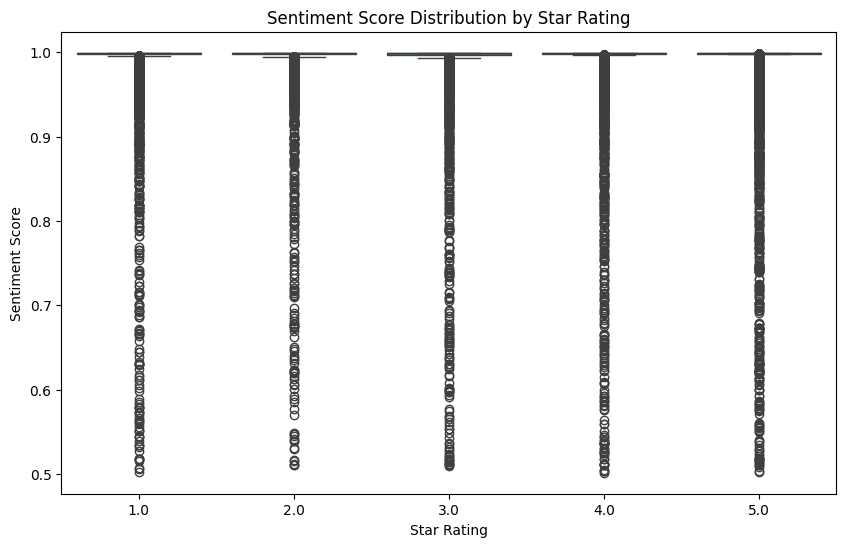

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.boxplot(x='stars', y='sentiment_score', data=df_flat)
plt.title('Sentiment Score Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.show()

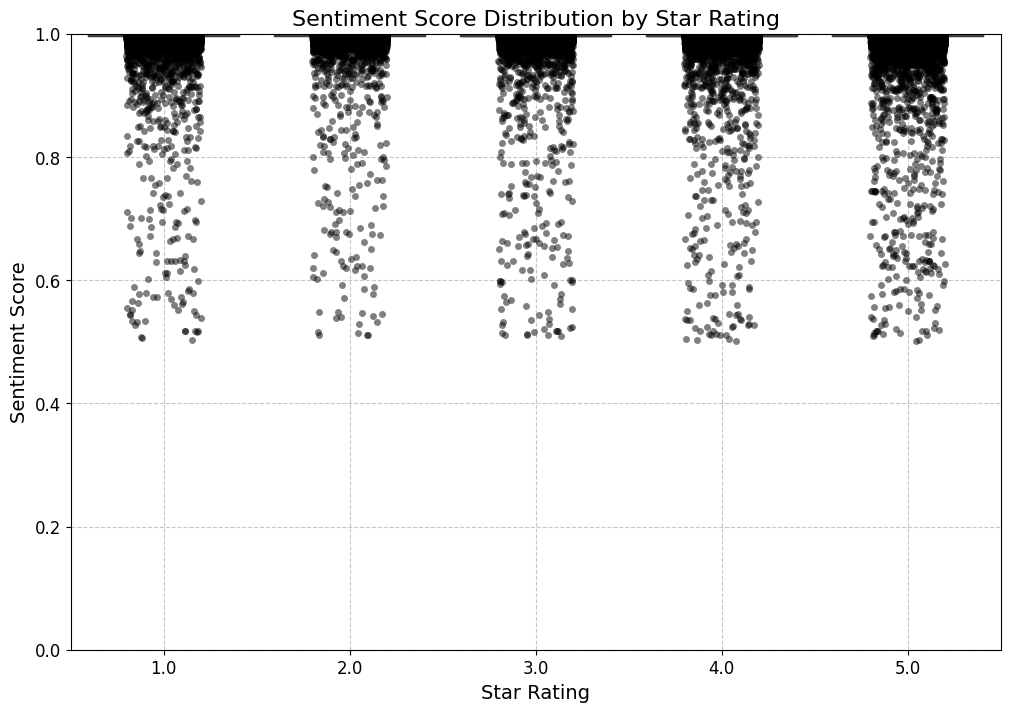

In [43]:
# 박스 플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(x='stars', y='sentiment_score', data=df_flat, showfliers=False, linewidth=2.5)
sns.stripplot(x='stars', y='sentiment_score', data=df_flat, color='black', alpha=0.5, jitter=0.2, size=5)
plt.ylim(0, 1)  # Y축을 0부터 1까지 설정
plt.title('Sentiment Score Distribution by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [9]:
### 결과 확인

In [ ]:
df['sentence_counts'].sum()

228496

In [ ]:
df[df['stars'] < 3.0]['sentiment_analysis'][3]

[('The service is going to be slooooww.', 'NEGATIVE', 0.9994365572929382),
 ('And the food okay.', 'NEGATIVE', 0.9987574815750122),
 ('Do not come here if you are with a group more than 4 if you have to be anywhere because it will be slow.',
  'NEGATIVE',
  0.999492883682251),
 ('I came with a group and we were the only ones around and the service was still a mess.',
  'NEGATIVE',
  0.9994968175888062),
 ('There were multiple servers around who watched one server struggle.',
  'NEGATIVE',
  0.9994366765022278),
 ('I felt bad for her.', 'NEGATIVE', 0.998433530330658),
 ('She was making drinks, serving, and running food.',
  'POSITIVE',
  0.9981197714805603)]

## Vader 모델

In [47]:
!pip install vaderSentiment

In [50]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentences = ['The service is going to be slooooww.']


analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

The service is going to be slooooww.----------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [61]:
rows = []

# 각 문장에 대해 VADER 감성 분석 수행
for _, row in df.iterrows():
    review_id = row['review_id']
    user_id = row['user_id']
    business_id = row['business_id']
    stars = row['stars']
    useful = row['useful']
    funny = row['funny']
    cool = row['cool']
    date = row['date']
    sentences_list = ast.literal_eval(row['sentences'])
    for sentence in sentences_list:
        vs = analyzer.polarity_scores(sentence)
        rows.append([review_id, user_id, business_id, stars, useful, funny, cool, date, sentence, vs['compound'], vs['pos'], vs['neg'], vs['neu']])

# 새로운 데이터프레임 생성
results_df = pd.DataFrame(rows, columns=['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'date', 'sentence', 'compound_score', 'pos_score', 'neg_score', 'neu_score'])

   review_id  user_id  business_id  stars  useful  funny  cool  \
0    1443659   607521       108373    5.0       0      0     0   
1    1443659   607521       108373    5.0       0      0     0   
2    1044648   182108       134961    5.0       0      0     0   
3    1044648   182108       134961    5.0       0      0     0   
4    1044648   182108       134961    5.0       0      0     0   

                  date                                           sentence  \
0  2017-01-14 21:23:10    Found 51st Deli on Uber Eats and we loved it!!!   
1  2017-01-14 21:23:10            I can't wait to check it out in person!   
2  2017-08-07 23:48:51  Love love love this place for HH n dinner is g...   
3  2017-08-07 23:48:51  Its ok for brunch, not as great as what people...   
4  2017-08-07 23:48:51       The Asian Nachos are the dish to get for HH.   

   compound_score  pos_score  neg_score  neu_score  
0          0.6981      0.347      0.000      0.653  
1          0.0000      0.000      

<ipython-input-68-ae8a65b87300>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='compound_score', data=results_df, showfliers=False, palette='Set3')


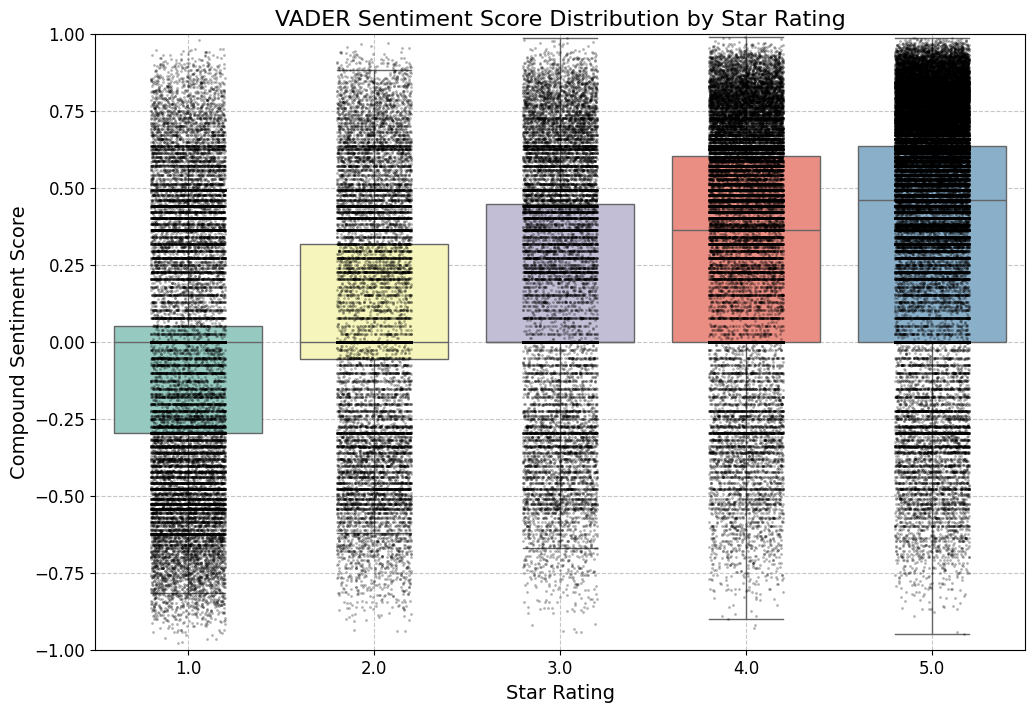

In [68]:
# 박스 플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(x='stars', y='compound_score', data=results_df, showfliers=False, linewidth=1.5, palette='Set3')
sns.stripplot(x='stars', y='compound_score', data=results_df, color='black', alpha=0.3, jitter=0.2, size=2)
plt.ylim(-1, 1)  # Y축을 -1부터 1까지 설정
plt.title('VADER Sentiment Score Distribution by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Compound Sentiment Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [42]:
# 결과 데이터프레임 확인
results_df.to_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/sentiment_analysis_result/Vader_sentiment_analysis_result.csv', index=False)

In [41]:
results_df.drop(['user_id','business_id','useful','funny','cool','date'],axis=1)

,review_id,stars,sentence,compound_score,positive_score,neutral_score,negative_score
0,1443659,5.0,Found 51st Deli on Uber Eats and we loved it!!!,0.989771,0.991007,0.007758,0.001236
1,1443659,5.0,I can't wait to check it out in person!,0.985175,0.986700,0.011776,0.001525
2,1044648,5.0,Love love love this place for HH n dinner is g...,0.989841,0.991794,0.006252,0.001954
3,1044648,5.0,"Its ok for brunch, not as great as what people...",-0.041061,0.229078,0.500784,0.270139
4,1044648,5.0,The Asian Nachos are the dish to get for HH.,0.397284,0.408822,0.579640,0.011538
...,...,...,...,...,...,...,...
228491,5916423,1.0,Won't go back.,-0.121095,0.092444,0.694016,0.213540
228492,1847631,5.0,Coma is my go to coffee shop.,0.906624,0.908743,0.089138,0.002119
228493,1847631,5.0,Their food and beverages are consistently deli...,0.985733,0.987232,0.011269,0.001499
228494,1847631,5.0,Online ordering is super easy or you can go in...,0.910056,0.912051,0.085953,0.001995


## twitter-roberta-base-sentiment

In [15]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm import tqdm

# 모델과 토크나이저 로드
print("모델과 토크나이저 로드 중...")
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
print("모델과 토크나이저 로드 완료")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"모델과 토크나이저 로드 완료 (디바이스: {device})")

# RoBERTa 감성 분석 함수 정의
def polarity_scores_roberta(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs)
    scores = outputs.logits.detach().cpu().numpy()[0]  # .cpu()를 사용하여 GPU 텐서를 CPU로 이동
    scores = softmax(scores)
    scores_dict = {
        "roberta_negative": scores[0],
        "roberta_neutral": scores[1],
        "roberta_positive": scores[2]
    }
    return scores_dict

# 새로운 데이터프레임을 만들기 위한 빈 리스트 생성
rows = []

# 각 문장에 대해 RoBERTa 감성 분석 수행
print("감성 분석 수행 중...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    review_id = row['review_id']
    user_id = row['user_id']
    business_id = row['business_id']
    stars = row['stars']
    useful = row['useful']
    funny = row['funny']
    cool = row['cool']
    date = row['date']
    sentences_list = ast.literal_eval(row['sentences'])
    for sentence in sentences_list:
        scores = polarity_scores_roberta(sentence)
        compound_score = scores["roberta_positive"] - scores["roberta_negative"]
        rows.append([review_id, user_id, business_id, stars, useful, funny, cool, date, sentence, compound_score, scores["roberta_positive"], scores["roberta_neutral"], scores["roberta_negative"]])

print("감성 분석 완료")

모델과 토크나이저 로드 중...
모델과 토크나이저 로드 완료
모델과 토크나이저 로드 완료 (디바이스: cuda)
감성 분석 수행 중...


100%|██████████| 30879/30879 [48:46<00:00, 10.55it/s]

감성 분석 완료


In [16]:
results_df = pd.DataFrame(rows, columns=['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'date', 'sentence', 'compound_score', 'positive_score', 'neutral_score', 'negative_score'])

In [19]:
results = results_df.drop(['user_id','business_id','useful','funny','cool','date'],axis=1)

In [39]:
results.head(25)

,review_id,stars,sentence,compound_score,positive_score,neutral_score,negative_score
0,1443659,5.0,Found 51st Deli on Uber Eats and we loved it!!!,0.989771,0.991007,0.007758,0.001236
1,1443659,5.0,I can't wait to check it out in person!,0.985175,0.986700,0.011776,0.001525
2,1044648,5.0,Love love love this place for HH n dinner is g...,0.989841,0.991794,0.006252,0.001954
3,1044648,5.0,"Its ok for brunch, not as great as what people...",-0.041061,0.229078,0.500784,0.270139
4,1044648,5.0,The Asian Nachos are the dish to get for HH.,0.397284,0.408822,0.579640,0.011538
5,1044648,5.0,Its an entree itself!,0.315035,0.360919,0.593198,0.045884
6,1044648,5.0,The other HH dishes are great too.,0.968269,0.970196,0.027877,0.001927
7,1044648,5.0,The creme brulee is amazing as with their othe...,0.983350,0.985115,0.013121,0.001765
8,1044648,5.0,The blueberry mojito is awesome along with the...,0.987648,0.989022,0.009603,0.001374
9,1044648,5.0,Great place to celebrate birthdays and such.,0.973192,0.974696,0.023800,0.001504


In [23]:
results.to_csv('/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/Roberta_sentiment_analysis_result.csv', index=False)

<ipython-input-22-edfafeeae5d9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='compound_score', data=results, showfliers=False, linewidth=1.5, palette='Set3')


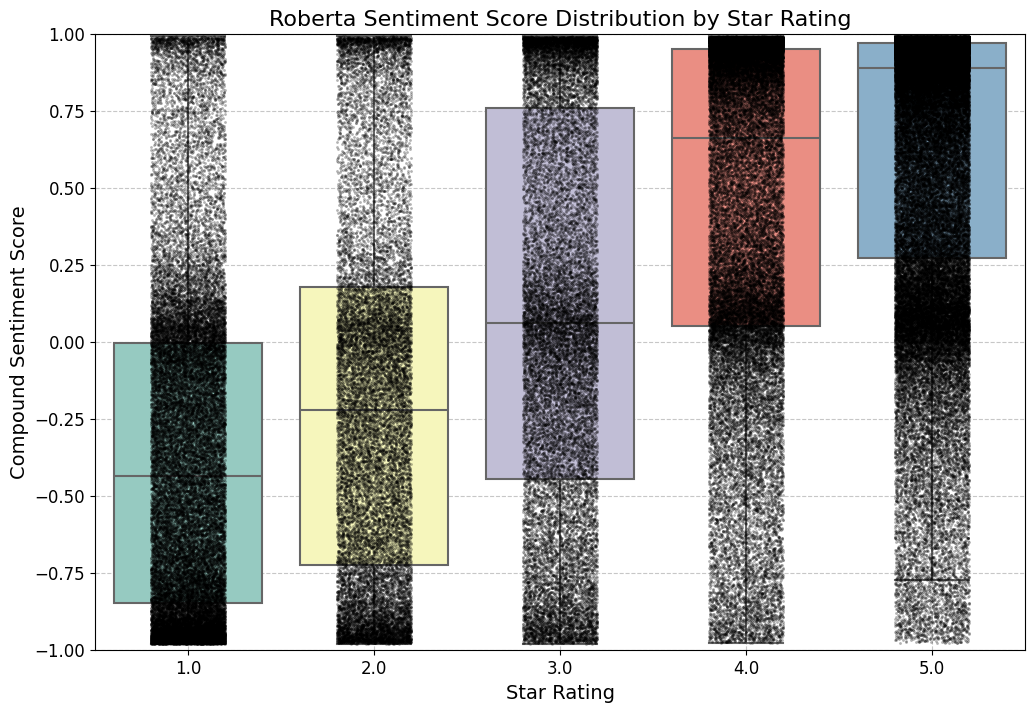

In [22]:
# 박스 플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(x='stars', y='compound_score', data=results, showfliers=False, linewidth=1.5, palette='Set3')
sns.stripplot(x='stars', y='compound_score', data=results, color='black', alpha=0.3, jitter=0.2, size=2)
plt.ylim(-1, 1)  # Y축을 -1부터 1까지 설정
plt.title('Roberta Sentiment Score Distribution by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Compound Sentiment Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


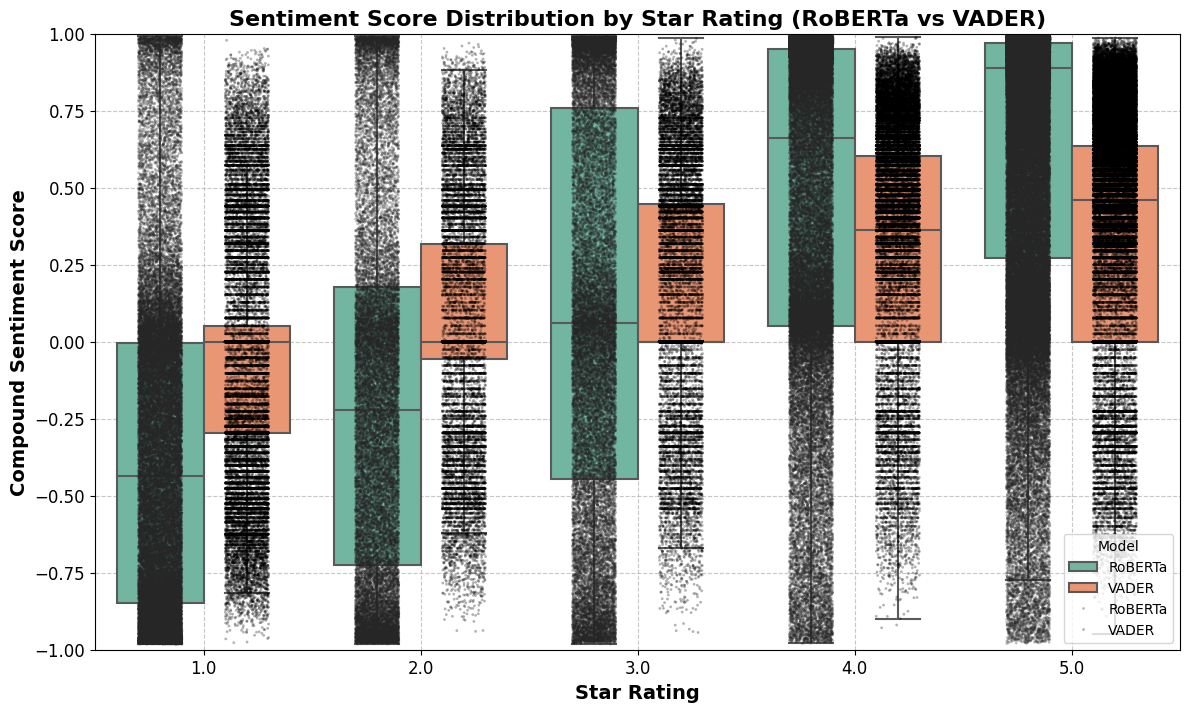

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load RoBERTa and VADER results
file_path_roberta = '/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/Roberta_sentiment_analysis_result.csv'
file_path_vader = '/content/drive/MyDrive/ASAC 데이터 분석 과정/기업연계_프로젝트/vader_sentiment_analysis_result.csv'

results_df_roberta = pd.read_csv(file_path_roberta)
results_df_vader = pd.read_csv(file_path_vader)

results_df_roberta = results_df_roberta.rename(columns={
    'compound_score': 'compound_score_roberta',
    'positive_score': 'positive_score_roberta',
    'neutral_score': 'neutral_score_roberta',
    'negative_score': 'negative_score_roberta'
})

results_df_vader = results_df_vader.rename(columns={
    'compound_score': 'compound_score_vader',
    'positive_score': 'positive_score_vader',
    'neutral_score': 'neutral_score_vader',
    'negative_score': 'negative_score_vader'
})

# Add a model identifier to distinguish the results
results_df_roberta['model'] = 'RoBERTa'
results_df_vader['model'] = 'VADER'

# Prepare the DataFrame for comparison
results_df_roberta = results_df_roberta[['review_id','stars','compound_score_roberta', 'model']]
results_df_vader = results_df_vader[['review_id','stars', 'compound_score_vader', 'model']]

# Rename 'compound_score' column to a common name for comparison
results_df_roberta = results_df_roberta.rename(columns={'compound_score_roberta': 'compound_score'})
results_df_vader = results_df_vader.rename(columns={'compound_score_vader': 'compound_score'})

# Combine the two DataFrames
combined_df = pd.concat([results_df_roberta, results_df_vader])

# Plot the combined results
plt.figure(figsize=(14, 8))
sns.boxplot(x='stars', y='compound_score', hue='model', data=combined_df, showfliers=False, linewidth=1.5, palette='Set2')
sns.stripplot(x='stars', y='compound_score', hue='model', data=combined_df, dodge=True, palette='dark:black', alpha=0.3, jitter=0.2, size=2)
plt.ylim(-1, 1)
plt.title('Sentiment Score Distribution by Star Rating (RoBERTa vs VADER)', fontsize=16, weight='bold')
plt.xlabel('Star Rating', fontsize=14, weight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.show()

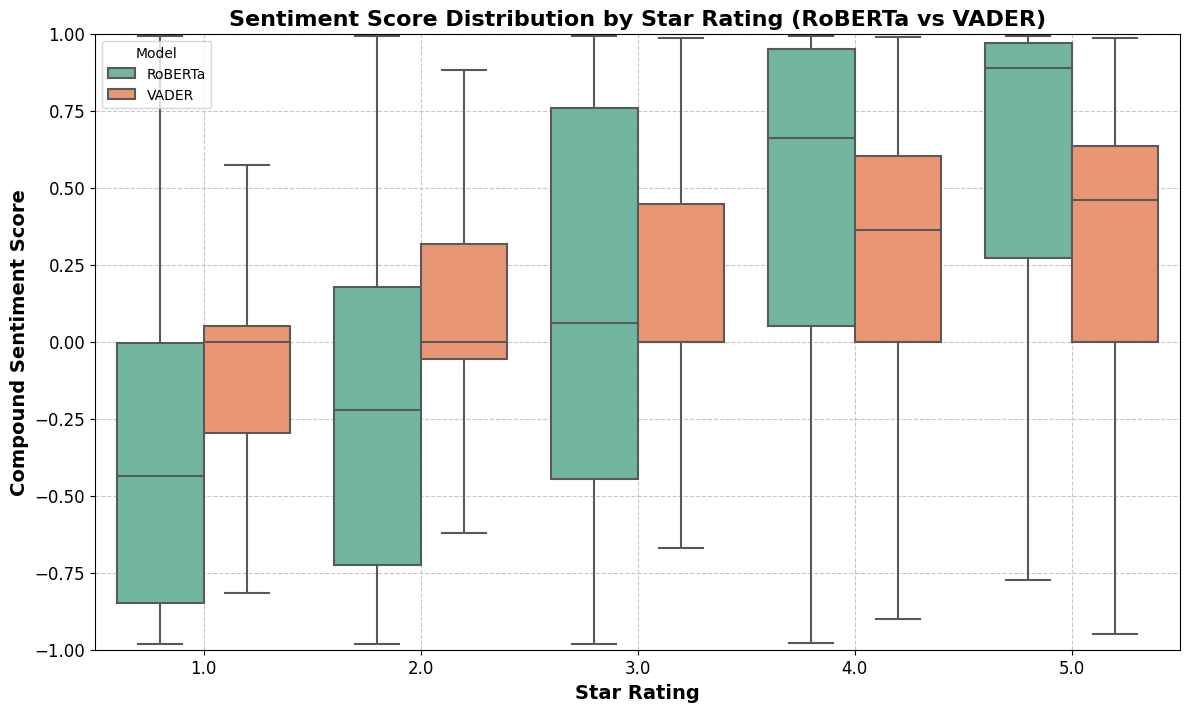

In [38]:
# Plot the combined results
plt.figure(figsize=(14, 8))
sns.boxplot(x='stars', y='compound_score', hue='model', data=combined_df, showfliers=False, linewidth=1.5, palette='Set2')
#sns.stripplot(x='stars', y='compound_score', hue='model', data=combined_df, dodge=True, palette='dark:black', alpha=0.3, jitter=0.2, size=2)
plt.ylim(-1, 1)
plt.title('Sentiment Score Distribution by Star Rating (RoBERTa vs VADER)', fontsize=16, weight='bold')
plt.xlabel('Star Rating', fontsize=14, weight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.show()

# 생성형 요약(Summarization)

## T5
- Text to Text Transfer Transformer
- 통일된 접근법: T5는 텍스트를 텍스트로 변환하는 일관된 접근 방식을 사용하여 키워드 생성 등 다양한 작업을 수행
- 다양한 작업 수행 능력: 텍스트 요약, 번역, 질문 생성, 키워드 생성 등 여러 작업을 하나의 모델로 수행

In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
from multiprocessing import Pool, set_start_method, cpu_count
from tqdm import tqdm
import numpy as np
import torch

# 'spawn' 시작 방법 설정
set_start_method('spawn', force=True)

# 1. 토크나이저와 모델 로드
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# 2. 텍스트 요약 함수 정의
def summarize_text(text):
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(input_ids=input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

# 키워드 추출

## T5 과학 아티클 fine-tuning 모델

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("Voicelab/vlt5-base-keywords")
tokenizer = T5Tokenizer.from_pretrained("Voicelab/vlt5-base-keywords")

task_prefix = "Keywords: "
# inputs = [
#     "Christina Katrakis, who spoke to the BBC from Vorokhta in western Ukraine, relays the account of one family, who say Russian soldiers shot at their vehicles while they were leaving their village near Chernobyl in northern Ukraine. She says the cars had white flags and signs saying they were carrying children.",
#     "Decays the learning rate of each parameter group by gamma every step_size epochs. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.",
#     "Hello, I'd like to order a pizza with salami topping.",
# ]

for sample in df.loc[:10,'text']:
    input_sequences = [task_prefix + sample]
    input_ids = tokenizer(
        input_sequences, return_tensors="pt", truncation=True
    ).input_ids
    output = model.generate(input_ids, no_repeat_ngram_size=3, num_beams=4)
    predicted = tokenizer.decode(output[0], skip_special_tokens=True)
    results.append({"text": sample, "keywords": predicted})


results_df = pd.DataFrame(results)
#    print(sample, "\n --->", predicted)

#First time there and it was excellent!!!
#It feels like your are entering someone's home.
#The waiters there funny and nice. The food come out very quickly and it is phenomenal!!!
#Definitely will be going back to this place.

# ---> food, vegetable, waiters


config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. 

The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker. 
 ---> NJ, food, quicker, waitstaff
Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer

전체 합치기

In [ ]:
for sample in group_temp.loc[:10,'text']:
    input_sequences = [task_prefix + sample]
    input_ids = tokenizer(
        input_sequences, return_tensors="pt", truncation=True
    ).input_ids
    output = model.generate(input_ids, no_repeat_ngram_size=3, num_beams=4)
    predicted = tokenizer.decode(output[0], skip_special_tokens=True)
    print(sample, "\n --->", predicted, "\n")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Ate here for the 1st time on Saturday 08/07/2020. 
The food was ok, had the Lobster Boil . The Lobster was ok for a soft shelled Lobster. The Crabs were soggy and mushy. The Clams were gummy and snotty . The headed shrimp were large and tasty. All the items were precooked, obviously. The fish spread was decent , also had the Fried Shrimp and Shrimp scampi  which were decent. BYOB ... ... The atmosphere was nice except for the zillion Flies. I'll be back with a six pack Absolutely fantastic!!!!  I'll be back for sure. Fried lobster tail was delicious. Five star for sure. I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and a few were not cooked all the way. So given the food experience it was nothing like the reviews we read. Why I a

## T5 레스토랑 기반 fine-tuning 모델
- NUSTM/restaurant-t5-base

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

input_ids = tokenizer(
   "The pizza here is delicious!!", return_tensors="pt"
).input_ids  # Batch size 1
outputs = model.generate(input_ids=input_ids,num_beams=4)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# T5 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

# 입력 텍스트
input_text = '''Cute interior and owner gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today.
Cheese curds were very good and very filling.
Really like that sandwiches come w salad, esp after eating too many curds!
Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked.
Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses.
Lots of beer and wine as well as limited cocktails.
Next time I will try one of the draft wines'''

input_ids = tokenizer(input_text, return_tensors="pt").input_ids
# 텍스트 생성 (키워드 추출)
outputs = model.generate(input_ids, num_beams=4)
predicted_keywords = tokenizer.decode(outputs[0], skip_special_tokens=True,)

print(f"Predicted Keywords: {predicted_keywords}")

In [ ]:
input_text = '''If you decide to eat here, \
just be aware it is going to take about 2 hours from beginning to end.
We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience.
The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant.
We have just had too many experiences where we spent way too long waiting.
We usually opt for another diner or restaurant on the weekends, in order to be done quicker'''

input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# 텍스트 생성 (키워드 추출)
outputs = model.generate(input_ids, num_beams=4)
predicted_keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Predicted Keywords: {predicted_keywords}")

In [ ]:
input_text = "Don't be stupid enough to eat here is. It is expensive and crappy.   Just eat at the cafeteria. My friends and myself came to humpty's to have a nice breakfast and it was horrid and a disaster. the service was fine, the food was DESPICABLE. My friend ordered the chicken louie the mashed potatoes tasted like acid reflux and the chicken was so rubbery she couldn't eat half of it. The ground beef in the Mexican scrambler was questionable too. My other friend ordered the crunchy chicken parmesan the pasta was watery and definitely unappealing and the vegetables were cold and clearly frozen. we all feel sick. "
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# 텍스트 생성 (키워드 추출)
outputs = model.generate(input_ids)
predicted_keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Predicted Keywords: {predicted_keywords}")

Predicted Keywords: humpty's humpty


## KeyBert

- 핵심 문장을 먼저 뽑고 여기에서 키워드 추출
- 양방향 문맥 이해: BERT는 양방향 문맥을 고려하여 텍스트를 이해하는 것에 효과적이다.
- 주로 텍스트 분류, 질문 답변, 문장 관계 예측에 사용됨.


[참고] https://iopscience.iop.org/article/10.1088/1742-6596/1992/4/042077/pdf

In [ ]:
!pip install keybert

# 토픽 추출

## Bertopic

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Bert 모델과 토크나이저 로드
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def extract_key_sentences(text, num_sentences=3):
    sentences = text.split('.')
    embeddings = []

    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt')
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())

    similarities = cosine_similarity(embeddings)
    key_sentences = sorted(range(len(similarities)), key=lambda i: similarities[i].sum(), reverse=True)[:num_sentences]

    return [sentences[i] for i in key_sentences]

In [ ]:
extract_key_sentences(group_temp['text'][0])

[' \n\nI ordered to go my order was ready in 10 minutes \n\nThe staff was very polite \n\nMy food was hot, fresh and tasty! The potion of coleslaw was huge an my lobster was a nice size',
 " Can't wait to return!! Great little spot and best of all BYOB !!!!\nLove it \n\nIs the food was fresh coat and they brought in the stone crabs that night on ice !  The boiled shrimp are great and the outside seating makes it feel very old Florida which is cool  , oysters Rockefeller was  pretty good",
 " The establishment makes you feel so comfortable and warm you don't want to leave! I had the Cuban Empanadas's and they were delicious  I ordered the baked beans also and they were some of the best I've ever had"]

In [ ]:
extract_key_sentences(df['text'][0])

[' \n\nThe food is good, but it takes a very long time to come out',
 ' We usually opt for another diner or restaurant on the weekends, in order to be done quicker',
 'If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end']

In [ ]:
df['text'][0]

"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 리뷰 데이터를 LDA를 사용하여 토픽 모델링
def topic_modeling(reviews, num_topics=5, num_keywords=5):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews)

    lda = LatentDirichletAllocation(n_components=num_topics)
    lda.fit(X)

    topics = []
    for idx, topic in enumerate(lda.components_):
        keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_keywords - 1:-1]]
        topics.append(keywords)

    return topics

#### 불용어 처리 전 예시

In [ ]:
# # 예시 데이터
reviews = [
    "The food was great and the service was excellent.",
    "I love the ambiance but the food was just okay.",
    "The pasta was delicious and the wine selection was superb."
]

# 토픽별 키워드 추출
topics = topic_modeling(reviews, num_topics=3, num_keywords=5)

for idx, topic in enumerate(topics):
    print(f"Topic {idx+1}: {topic}")


extract_keywords(reviews[0])

Topic 1: ['the', 'was', 'wine', 'superb', 'selection']
Topic 2: ['food', 'and', 'the', 'was', 'ambiance']
Topic 3: ['was', 'the', 'food', 'and', 'great']


['food', 'great', 'was', 'and', 'the', 'service']

#### 불용어 처리 후

In [ ]:
# 예시 데이터
reviews = [
    "The food was great and the service was excellent.",
    "I love the ambiance but the food was just okay.",
    "The pasta was delicious and the wine selection was superb."
]

preprocessed_reviews = [preprocess_text(review) for review in reviews]
topics_v2 = topic_modeling(preprocessed_reviews, num_topics=3, num_keywords=5)
for idx, topic in enumerate(topics_v2):
    print(f"Topic {idx+1}: {topic}")

extract_keywords(preprocessed_reviews[0])

Topic 1: ['food', 'love', 'okay', 'ambiance', 'excellent']
Topic 2: ['wine', 'superb', 'selection', 'pasta', 'delicious']
Topic 3: ['service', 'great', 'excellent', 'love', 'ambiance']


['food', 'great', 'excellent', 'service']

#### 실제 리뷰 데이터로 실험

In [ ]:
preprocessed_reviews = [preprocess_text(review) for review in df.loc[:1,'text']]

topics_v2 = topic_modeling(preprocessed_reviews, num_topics=3, num_keywords=5)
for idx, topic in enumerate(topics_v2):
  print(f"Topic {idx+1}: {topic}")

Topic 1: ['like', 'curds', 'cheese', 'come', 'good']
Topic 2: ['waitstaff', 'want', 'decide', 'way', 'done']
Topic 3: ['waitstaff', 'want', 'decide', 'way', 'done']
